In this notebook, I'm going to do some experimentation with xgboost on only the real clinical data

In [1]:
!pip install xlrd

    100% |████████████████████████████████| 112kB 3.9MB/s 
menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 3.0.2 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.4.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import sklearn.metrics

In [2]:
import os
import re
from collections import Counter
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
os.getcwd()

'/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage'

In [4]:
#use this cell when working online
path = '/floyd/home/notebooks'
data_path = '/floyd/home/data'

In [6]:
os.listdir('/Users/jjaskolkambp/Desktop/machine learning/my_projects/data/ED triage project')

['bch_data_breakdown.xlsx',
 '.DS_Store',
 'first_model.pth',
 '500_cleaned.csv',
 'BCH ED visits FY1819_with additions.xlsx',
 'sample_cleaned.xlsx',
 'models',
 'EGH ED visits FY1819_with additions.xlsx',
 'BERT',
 '.gitattributes',
 '.ipynb_checkpoints',
 '.git',
 'data',
 'ed_databunch',
 'jj_modified_bch_data.xlsx',
 'clean_sentiment_columns.csv',
 'bert-temp']

In [7]:
#use this cell when working from home
path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage'
data_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/data/ED triage project'

In [14]:
clin = pd.read_excel(data_path + '/jj_modified_bch_data.xlsx')

In [17]:
len(clin)

136993

In [10]:
clin.columns

Index(['ID', 'ChartNumber', 'EncounterNumber', 'TriageLevel', 'AgeNumber',
       'AgeInYrs', 'GenderDesc', 'Triage Date & Time', 'Reg Date & Time',
       'PIA Date & Time', 'Disposition Date & Time', 'DischargeDisposition',
       'DischargeDispositionDesc', 'Left ED Date & Time',
       'PresentingComplaint', 'PresentingComplaintDesc', 'MainDiagnosisCode',
       'MainDiagnosisCodeDesc', 'AdmitLocation', 'PatientService',
       'SubjectiveNotes', 'InfectionControlScreening', 'MedicalHistory',
       'BloodPressure_LastEDReading', 'O2Saturation_LastEDReading',
       'Pulse_LastEDReading', 'Temperature_LastEDReading',
       'Are you feeling feverish or have had shakes or chills in the last 24 hours?',
       'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
       'Do you have a new Rash?',
       'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
       'Have you travelled outside of Canada/U

In [18]:
discharge_count = Counter(clin['DischargeDisposition']); discharge_count

Counter({17: 112819,
         62: 398,
         7: 15740,
         16: 628,
         63: 2165,
         6: 1173,
         13: 1731,
         72: 191,
         8: 286,
         30: 573,
         90: 42,
         40: 486,
         61: 88,
         64: 547,
         12: 91,
         14: 27,
         9: 6,
         71: 2})

In [19]:
discharge_count2 = Counter(clin['DischargeDispositionDesc']); discharge_count2

Counter({'Discharge to private home, condo, apt without support service/referral': 112819,
         'Left at his/her own risk post-initial treatment': 398,
         'Admit to reporting facility as inpatient to another unit from amb care': 15740,
         'Discharge to private home, condo, apt with support service/referral': 628,
         'Left After Triage': 2165,
         'Admit to reporting facility as inpatient to SCU or OR from amb care': 1173,
         'Intra-facility transfer to ED': 1731,
         'Died in Facility': 191,
         'Transfer to another acute care facility directly from amb care': 286,
         'Transfer to Residential care': 573,
         'Transfer to correctional facility': 42,
         'Transfer to Group/supportive living': 486,
         'Left at his/her own risk following registration': 88,
         'Left After Initial Assessment': 547,
         'Intra-facility transfer to day surgery': 91,
         'Intra-facility transfer to clinic': 27,
         'Transfer t

In [41]:
triage_count = Counter(clin['TriageLevel'])
triage_count

Counter({3.0: 73424,
         2.0: 43936,
         4.0: 14091,
         1.0: 1472,
         5.0: 3980,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan:

In [17]:
comp_count = Counter(clin['PatientService']); comp_count

Counter({nan: 120106,
         'General Surgery': 1452,
         'Respirology': 895,
         'General Medicine': 6091,
         'INTENSIVE CARE UNIT': 454,
         'Cardiology': 2678,
         'Oncology': 491,
         'Palliative': 170,
         'AD PALLIATIVE': 48,
         'Genitourinary': 688,
         'Paediatrics': 1248,
         'Mental Health': 596,
         'Orthopaedics': 352,
         'MH Child & Adolescent': 390,
         'AD Oncology': 9,
         'Neurology': 583,
         'ALC General Medicine': 211,
         'ALC General Surgery': 35,
         'Acute Care for Elders': 62,
         'ALC Neurology': 93,
         'ALC Cardiology': 86,
         'ALC Respirology': 29,
         'ALC Orthopaedics': 145,
         'Neonatal Retro Transfers': 4,
         'Newborn': 4,
         'Obstetrics': 32,
         'ALC Oncology': 9,
         'AD General Medicine': 6,
         'AD Acute Care for Elders': 3,
         'AD Respirology': 2,
         'ALC ACUTE CARE FOR EDLERS': 5,
         'AD

In [20]:
clin['service'] = clin['PatientService'].astype('str').map(
    {'nan': 'discharge',
         'General Surgery': 'sadmit',
         'Respirology': 'madmit',
         'General Medicine': 'madmit',
         'INTENSIVE CARE UNIT': 'ICU',
         'Cardiology': 'madmit',
         'Oncology': 'madmit',
         'Palliative': 'madmit',
         'AD PALLIATIVE': 'madmit',
         'Genitourinary': 'sadmit',
         'Paediatrics': 'madmit',
         'Mental Health': 'madmit',
         'Orthopaedics': 'sadmit',
         'MH Child & Adolescent': 'madmit',
         'AD Oncology': 'madmit',
         'Neurology': 'madmit',
         'ALC General Medicine': 'madmit',
         'ALC General Surgery': 'sadmit',
         'Acute Care for Elders': 'madmit',
         'ALC Neurology': 'madmit',
         'ALC Cardiology': 'madmit',
         'ALC Respirology': 'madmit',
         'ALC Orthopaedics': 'madmit',
         'Neonatal Retro Transfers': 'madmit',
         'Newborn': 'madmit',
         'Obstetrics': 'madmit',
         'ALC Oncology': 'madmit',
         'AD General Medicine': 'madmit',
         'AD Acute Care for Elders': 'madmit',
         'AD Respirology': 'madmit',
         'ALC ACUTE CARE FOR EDLERS': 'madmit',
         'AD Cardiology': 'madmit',
         'AD Neurology': 'madmit',
         'ALC Palliative': 'madmit',
         'AD General Surgery': 'sadmit'})

In [21]:
service_count = Counter(clin['service'])
service_count

Counter({'discharge': 120106, 'sadmit': 2528, 'madmit': 13905, 'ICU': 454})

In [21]:
clin['target2'] = clin['service'].map({'discharge': 1, 'madmit': 2, 'sadmit': 3, 'ICU': 4})

In [29]:
o2sat = [item if item[-1] != '%' else item[:-1] for item in clin['O2Saturation_LastEDReading'].astype('str')]
o2sat = [np.nan if item == 'nan' else float(item) for item in o2sat] 
clin['o2sat'] = o2sat

In [30]:
pulse = clin['Pulse_LastEDReading']
pulse = [re.sub("[^0-9]", "", str(item)) for item in pulse]
pulse = [np.nan if item == '' else float(item) for item in pulse] 
#set(pulse)
clin['pulse'] = pulse

In [31]:
temp = clin['Temperature_LastEDReading']
temp = [re.sub("[^0-9]", "", str(item)) for item in temp]
temp = [np.nan if item == '' else float(item) for item in temp] 
temp = [item/10 if item > 100 else item for item in temp]
temp = [np.nan if item > 40  else item for item in temp]
#set(temp)
clin['temp'] = temp

**bptrans** parses the blood pressure column into systolic and diastolic, **fixencode** does some preprocessing on text 

In [32]:
def bptrans(bp):
    if pd.isnull(bp):
        return [np.nan, np.nan]
    res = []
    for x in bp.split('/'):
        try:
            float(x)
            res =  [float(x) for x in bp.split('/')]
        except: 
            res =  [np.nan, np.nan]
        return res

def fixencode(s):
    if pd.isnull(s):
        s = "None"
    s=s.replace('<LT><LF>',',')
    s=s.replace('Pt.', 'patient')
    s=s.replace('Pt', 'patient')
    s= s.replace('pt.', 'patient')
    s=s.replace('pt', 'patient')
    s = s.replace('y/o', 'year old')
    s = s.replace('c/o', 'complains of')
    s = s.replace('C/o', 'complains of')
    return s

In [33]:
clin['BP'] = clin.BloodPressure_LastEDReading.map(bptrans)
clin[['systolic', 'diastolic']] = pd.DataFrame(clin.BP.tolist(), index= clin.index)
clin["Gender"] = clin.GenderDesc.map(lambda x: 1 if x == "Male" else 0)

In [34]:
inf_screen_df = clin[[
    'Are you feeling feverish or have had shakes or chills in the last 24 hours?',
       'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
       'Do you have a new Rash?',
       'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
       'Have you travelled outside of Canada/USA in the last 3 weeks?',
       'Have you had contact with a sick person who has travelled outside of Canada/USA in the last 3 weeks?',
       'Have you received Health Care in another country in the last 2 years?',
       'Do you have a new/worse cough or shortness of breath?',
       'If so, select all countries that apply',
       'If so, select all infectious diseases that apply']]

In [35]:
subj_df = clin[['MedicalHistory','SubjectiveNotes']]

In [36]:
tab_df = clin[['ID', 'TriageLevel',
       'AgeInYrs', 'GenderDesc', 'DischargeDisposition',
       'PresentingComplaint', 'PresentingComplaintDesc', 'AdmitLocation', 'PatientService',
       'BloodPressure_LastEDReading','systolic', 'diastolic','temp','pulse','o2sat']]
        #'O2Saturation_LastEDReading', 'Pulse_LastEDReading', 'Temperature_LastEDReading']]

In [16]:
admit_count= Counter(clin['AdmitLocation']); admit_count

Counter({nan: 120106,
         'N.SUR GEN': 1024,
         'N.MED CARD': 1738,
         'N.ER IN': 1186,
         'N.MED SIX': 604,
         'N.CC ICU': 455,
         'N.CC CCU': 584,
         'N.MED ONC': 1024,
         'N.MAU': 2365,
         'N.SIMCU': 301,
         'N.MED CPU': 329,
         'N.MED GER': 1070,
         'N.MED CT': 144,
         'N.WC PAED': 1291,
         'N.ERMH IN': 29,
         'N.MED SIM': 450,
         'N.SUR ORTH': 661,
         'N.MH CHADI': 152,
         'N.MH GER': 68,
         'N.MH GENB': 217,
         'N.MH INTEN': 234,
         'N.MED RESP': 944,
         'N.MED NEUR': 921,
         'N.SUR SS': 582,
         'N.MH CHAD': 210,
         'N.WC POST': 119,
         'N.MH GENC': 47,
         'N.MED DIAL': 48,
         'N.CC NICU': 5,
         'N.WC LD': 2,
         'N.WC LDN': 1,
         'N.MAIN OR': 1,
         'N.MED STTU': 1,
         'N.MED FLEX': 10,
         'N.MED DSU': 69,
         'N.SUR DSU': 1})

In [22]:
clin['outcome'] = clin['AdmitLocation'].astype('str').map(
{'N.CC CCU': 'ICU',
 'N.CC ICU': 'ICU',
 'N.ER IN' : 'madmit',
 'N.ERMH IN': 'madmit',
 'N.MAU': 'madmit',
 'N.MED CARD': 'madmit',
 'N.MED CPU': 'madmit',
 'N.MED CT': 'madmit',
 'N.MED GER': 'madmit',
 'N.MED DIAL': 'madmit',
 'N.MED NEUR': 'madmit',
 'N.MED ONC': 'madmit',
 'N.MED RESP': 'madmit',
 'N.MED SIM': 'madmit',
 'N.MED SIX': 'madmit',
 'N.MH CHAD': 'madmit',
 'N.MH CHADI': 'madmit',
 'N.MH GENB': 'madmit',
 'N.MH GER': 'madmit',
 'N.MH INTEN': 'madmit',
 'N.SIMCU': 'ICU',
 'N.SUR GEN': 'sadmit',
 'N.SUR ORTH': 'sadmit',
 'N.SUR SS': 'sadmit',
 'N.WC PAED': 'madmit',
 'N.WC POST': 'madmit',
 'N.MH GENC': 'madmit',
 'N.CC NICU': 'ICU',
 'N.WC LD': 'sadmit',
  'N.WC LDN': 'sadmit',
  'N.MAIN OR': 'sadmit',
  'N.MED STTU': 'madmit',
  'N.MED FLEX': 'madmit',
    'N.MED DSU': 'madmit',
    'N.SUR DSU': 'sadmit',
 'nan': 'discharge'})

In [23]:
clin['target'] = clin['outcome'].map({'discharge': 1, 'madmit': 2, 'sadmit': 3, 'ICU': 4})

In [34]:
outcome_count = Counter(clin['outcome']); outcome_count

Counter({'discharge': 120106, 'sadmit': 2272, 'madmit': 13270, 'ICU': 1345})

In [35]:
target_count = Counter(clin['target']); target_count

Counter({1: 120106, 3: 2272, 2: 13270, 4: 1345})

In [36]:
target2_count = Counter(clin['target2']); target2_count

Counter({1: 120106, 3: 2528, 2: 13905, 4: 454})

In [37]:
out_dict = {'discharge': 1, 'madmit': 2, 'sadmit': 3, 'ICU': 4}
out_dict = {v:k for k,v in out_dict.items()}
out_dict

{1: 'discharge', 2: 'madmit', 3: 'sadmit', 4: 'ICU'}

In [24]:
clin['discharge'] = clin['outcome'].map({'discharge': 1, 'madmit': 0, 'sadmit': 0, 'ICU': 0})

In [25]:
clin['dispo']= clin['outcome'].map({'discharge': np.nan, 'madmit': 1, 'sadmit': 2, 'ICU': 3})




Now we are going to split stuff up into features and train some models




In [44]:
features_ltd = clin[['systolic', 'diastolic', 'pulse', 'o2sat', 'temp', 'AgeInYrs', 'Gender']]
features = clin[['systolic', 'diastolic', 'pulse', 'o2sat', 'temp', 'AgeInYrs', 'Gender', 'PresentingComplaint', 'TriageLevel']]

In [45]:
target2 = clin['target2']
target1 = clin['target']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(features, target1) #, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
conf = confusion_matrix(y_test, preds); conf

array([[29754,   310,     0,     2],
       [ 2593,   690,     0,     4],
       [  504,    59,     0,     0],
       [  232,    96,     0,     5]])

In [47]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average = None)
rec = sklearn.metrics.recall_score(y_test,preds, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8573485764818736
f1:           [0.94234271 0.31067087 0.         0.02906977]
accuracy:     0.8890478554118368
precision:    [0.8993743  0.5974026  0.         0.45454545]
recall:       [0.98962283 0.20991786 0.         0.01501502]


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
target_dict = {'discharge': 1, 'madmit': 2, 'sadmit': 3, 'ICU': 4}

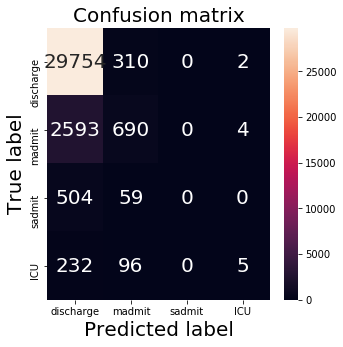

In [49]:
LABELS = target_dict.keys()  #['admit', 'discharge'] #lab_count.keys()

plt.figure(figsize=(5, 5))
sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()




So, now we are going to try the same but with different method for determining target




In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, target2) #, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
conf = confusion_matrix(y_test, preds); conf

array([[29627,   372,     0,     0],
       [ 2642,   806,     0,     0],
       [  631,    57,     0,     0],
       [   77,    37,     0,     0]])

In [55]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average = None)
rec = sklearn.metrics.recall_score(y_test,preds, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8585238214388159
f1:           [0.94089812 0.34152542 0.         0.        ]
accuracy:     0.8885806884872551
precision:    [0.89841405 0.6336478  0.         0.        ]
recall:       [0.98759959 0.2337587  0.         0.        ]


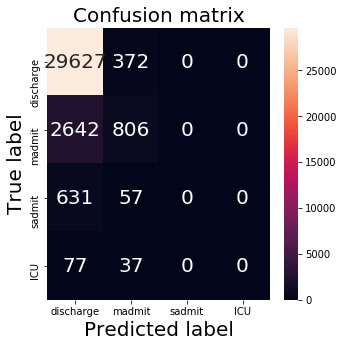

In [56]:
LABELS = target_dict.keys()  #['admit', 'discharge'] #lab_count.keys()

plt.figure(figsize=(5, 5))
sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [53]:
#check for overfitting
preds = xgc.predict(X_train)
conf = confusion_matrix(y_train, preds); conf

array([[89174,   971,     0,     0],
       [ 7854,  2512,     0,     0],
       [ 1691,   193,     0,     0],
       [  243,   106,     0,     0]])

What follows is going to be some work on hyperparameter selection and tuning as the model is underfitting

In [60]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


In [67]:
clin.columns

Index(['ID', 'ChartNumber', 'EncounterNumber', 'TriageLevel', 'AgeNumber',
       'AgeInYrs', 'GenderDesc', 'Triage Date & Time', 'Reg Date & Time',
       'PIA Date & Time', 'Disposition Date & Time', 'DischargeDisposition',
       'DischargeDispositionDesc', 'Left ED Date & Time',
       'PresentingComplaint', 'PresentingComplaintDesc', 'MainDiagnosisCode',
       'MainDiagnosisCodeDesc', 'AdmitLocation', 'PatientService',
       'SubjectiveNotes', 'InfectionControlScreening', 'MedicalHistory',
       'BloodPressure_LastEDReading', 'O2Saturation_LastEDReading',
       'Pulse_LastEDReading', 'Temperature_LastEDReading',
       'Are you feeling feverish or have had shakes or chills in the last 24 hours?',
       'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
       'Do you have a new Rash?',
       'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
       'Have you travelled outside of Canada/U

In [26]:
target_df = clin[['service','target2', 'target', 'outcome', 'discharge', 'dispo']]

In [27]:
target_df.to_csv(data_path  + '/targets.csv')

In [37]:
inf_screen_df.to_csv(data_path + '/inf_control_data.csv')

In [38]:
subj_df.to_csv(data_path + '/subj_data.csv')

In [39]:
tab_df.to_csv(data_path + '/tabular_data.csv')

In [40]:
med_hx = subj_df['MedicalHistory']

In [41]:
history = list(subj_df['MedicalHistory'].str[16:].astype('str'))

In [42]:
type(history)

list

In [43]:
split_hist = [item.split('<LT>LF>') for item in history if item != 'nan']

In [44]:
len(split_hist)

122211

In [45]:
split_hist[:25]

[['No Significant Medical History'],
 ['Substance Misuse'],
 ['ACS (Acute Coronary Syndrome)',
  'MI (Myocardial Infarction)',
  'triple a repair',
  'NIDDM (Non-Insulin-Dependent Diabetes Mellitus)',
  'Hypertension (HTN)',
  'bronchiectasis'],
 ['Hypertension (HTN)'],
 ['Seizure', 'Asthma', 'palpitations', 'leaky hrt valve'],
 ['No Significant Medical History'],
 ['No Significant Medical History'],
 ['No Significant Medical History'],
 ['Hypertension (HTN)', 'High Cholesterol', 'Gerd', 'Chronic Back Pain'],
 ['No Significant Medical History'],
 ['Dialysis Haemo/PD',
  'IDDM (Insulin-Dependent Diabetes Mellitus)',
  'CRF (Chronic Renal Failure)',
  'heart problem',
  'High Cholesterol'],
 ['Fibromyalgia'],
 ['enlarged liver'],
 ['Anxiety',
  'Autistic',
  'ADHD (Attention Deficit Hyperactivity Disorder)',
  'Depression',
  'Asthma',
  'Celiac'],
 ['No Significant Medical History'],
 ['IDDM (Insulin-Dependent Diabetes Mellitus)'],
 ['No Significant Medical History'],
 ['Hypertension (H

In [46]:
diagnoses = Counter()
for hx in split_hist:
    for item in hx:
        diagnoses[item] += 1

In [47]:
len(diagnoses)

29803

In [48]:
diagnoses.most_common()

[('No Significant Medical History', 48412),
 ('Hypertension (HTN)', 18790),
 ('High Cholesterol', 15828),
 ('NIDDM (Non-Insulin-Dependent Diabetes Mellitus)', 7976),
 ('High BP', 5142),
 ('Depression', 5061),
 ('Asthma', 4498),
 ('Anxiety', 3785),
 ('Hypothyroid', 3116),
 ('Thyroid', 3059),
 ('IDDM (Insulin-Dependent Diabetes Mellitus)', 2920),
 ('Diabetes', 2775),
 ('Arthritis', 1709),
 ('Acid Reflux', 1600),
 ('Gerd', 1498),
 ('COPD (Chronic Obstructive Pulmonary Disease)', 1479),
 ('MI (Myocardial Infarction)', 1446),
 ('GERD (Gastroesophageal Reflux Disease)', 1344),
 ('Anemia', 1143),
 ('Seizure', 1056),
 ('CHF (Congestive Heart Failure)', 1044),
 ('Atrial Fibrillation (A Fib)', 1041),
 ('Schizophrenia', 1027),
 ('Substance Misuse', 948),
 ('CVA (Cerebral vascular Accident)', 946),
 ('Dementia', 924),
 ('Enlarged Prostate', 809),
 ('Kidney Stones', 746),
 ('Immunizations up to Date', 725),
 ('Gout', 666),
 ('Migraines', 626),
 ('Osteoporosis', 621),
 ('Pacemaker/Cardioverter/Defib

In [70]:
dx_rank_dict = {item[0]:i+1 for i,item in enumerate(diagnoses.most_common())}

In [71]:
len(dx_rank_dict)

29803

In [72]:
dx_rank_dict.items()

dict_items([('No Significant Medical History', 1), ('Hypertension (HTN)', 2), ('High Cholesterol', 3), ('NIDDM (Non-Insulin-Dependent Diabetes Mellitus)', 4), ('High BP', 5), ('Depression', 6), ('Asthma', 7), ('Anxiety', 8), ('Hypothyroid', 9), ('Thyroid', 10), ('IDDM (Insulin-Dependent Diabetes Mellitus)', 11), ('Diabetes', 12), ('Arthritis', 13), ('Acid Reflux', 14), ('Gerd', 15), ('COPD (Chronic Obstructive Pulmonary Disease)', 16), ('MI (Myocardial Infarction)', 17), ('GERD (Gastroesophageal Reflux Disease)', 18), ('Anemia', 19), ('Seizure', 20), ('CHF (Congestive Heart Failure)', 21), ('Atrial Fibrillation (A Fib)', 22), ('Schizophrenia', 23), ('Substance Misuse', 24), ('CVA (Cerebral vascular Accident)', 25), ('Dementia', 26), ('Enlarged Prostate', 27), ('Kidney Stones', 28), ('Immunizations up to Date', 29), ('Gout', 30), ('Migraines', 31), ('Osteoporosis', 32), ('Pacemaker/Cardioverter/Defib', 33), ('ADHD (Attention Deficit Hyperactivity Disorder)', 34), ('Chronic Back Pain', 3

In [54]:
split_hist_len = [len(item) for item in split_hist]

In [56]:
hxdf = pd.DataFrame(split_hist_len)

In [57]:
hxdf.describe()

,0
count,122211.000000
mean,1.759964
std,1.409361
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,27.000000


In [58]:
lengths = Counter(split_hist_len); lengths

Counter({1: 80806,
         6: 1769,
         4: 6278,
         5: 3437,
         2: 17785,
         3: 10313,
         8: 481,
         9: 227,
         7: 855,
         13: 20,
         11: 57,
         10: 116,
         12: 30,
         15: 15,
         14: 9,
         17: 4,
         18: 2,
         16: 6,
         27: 1})

In [64]:
for k,v in sorted(lengths.items()):
    print (k, '{0:2f}%'.format(v*100/len(split_hist_len)))

1 66.120071%
2 14.552700%
3 8.438684%
4 5.137017%
5 2.812349%
6 1.447497%
7 0.699610%
8 0.393582%
9 0.185744%
10 0.094918%
11 0.046641%
12 0.024548%
13 0.016365%
14 0.007364%
15 0.012274%
16 0.004910%
17 0.003273%
18 0.001637%
27 0.000818%


So here's what I want to do now:
- I want to loop through each item in the split_hist list.
- For each of these items (lists), I want to make a list/tuple of possible history items
- To make this list, I will iterate through each entry in the item, check it's rank in the most common list
- then I will rank them according to their place in the most-common list and take up to 6
- will pad with zero for cases with less than 6 histories

In [88]:
ordered_hist = []
for item in split_hist:
    top_6 = []
    for hx in item:
        top_6.append((dx_rank_dict[hx], hx))
    #print (top_6)
    #print (sorted(top_6))
    ordered_hist.append(sorted(top_6))

In [100]:
#v2
ordered_hist = []
for item in split_hist:
    top_6 = []
    for hx in item:
        top_6.append((dx_rank_dict[hx], hx))
    sort = sorted(top_6)
    sort2 = [ii for i,ii in sort]
    if len(sort2) > 6:
        sort2 = sort2[:5]
    if len(sort2) < 6:
        pad_req = 6-len(sort2)
        i = 0
        while i < pad_req:
            sort2.append('n/a')
            i = i+1
        
    #print (top_6)
    #print (sorted(top_6))
    ordered_hist.append(sort2)

In [101]:
for item in ordered_hist[:20]:
    print (item)

['No Significant Medical History', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
['Substance Misuse', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
['Hypertension (HTN)', 'NIDDM (Non-Insulin-Dependent Diabetes Mellitus)', 'MI (Myocardial Infarction)', 'ACS (Acute Coronary Syndrome)', 'bronchiectasis', 'triple a repair']
['Hypertension (HTN)', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
['Asthma', 'Seizure', 'palpitations', 'leaky hrt valve', 'n/a', 'n/a']
['No Significant Medical History', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
['No Significant Medical History', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
['No Significant Medical History', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
['Hypertension (HTN)', 'High Cholesterol', 'Gerd', 'Chronic Back Pain', 'n/a', 'n/a']
['No Significant Medical History', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
['High Cholesterol', 'IDDM (Insulin-Dependent Diabetes Mellitus)', 'Dialysis Haemo/PD', 'CRF (Chronic Renal Failure)', 'heart problem', 'n/a']
['Fibromyalgia', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
['enlarged

In [103]:
medhx_df = pd.DataFrame(ordered_hist)

In [104]:
len(medhx_df)

122211

In [105]:
medhx_df.head()

,0,1,2,3,4,5
0,No Significant Medical History,n/a,n/a,n/a,n/a,n/a
1,Substance Misuse,n/a,n/a,n/a,n/a,n/a
2,Hypertension (HTN),NIDDM (Non-Insulin-Dependent Diabetes Mellitus),MI (Myocardial Infarction),ACS (Acute Coronary Syndrome),bronchiectasis,triple a repair
3,Hypertension (HTN),n/a,n/a,n/a,n/a,n/a
4,Asthma,Seizure,palpitations,leaky hrt valve,n/a,n/a


In [52]:
date_df = clin[['Triage Date & Time', 'Reg Date & Time',
       'PIA Date & Time', 'Disposition Date & Time', 'Left ED Date & Time']]

In [53]:
date_df.to_csv(data_path + '/date_data.csv')